# Imports

In [95]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import catboost
from catboost import CatBoostClassifier, Pool



# Constants

In [3]:
TARGETS = ['main_screen', 'invest', 'statement', 'phone_money_transfer',
       'own_transfer', 'credit_info', 'chat', 'card2card_transfer',
       'mobile_recharge', 'card_recharge']

# Data Load

In [12]:
train_target = pd.read_csv("alfabattle2_abattle_train_target.csv")

test_target = pd.read_csv("alfabattle2_prediction_session_timestamp.csv")
test_target["test"] = True

dataset = pd.concat([test_target, train_target], axis=0).reset_index(drop=True)
dataset.sort_values("timestamp", inplace=True)
dataset["test"].replace(np.NaN, False, inplace=True)
# dataset.loc[dataset["test"], "multi_class_target"] = "statement"
dataset.loc[dataset["test"], "session_id"] = np.arange(len(dataset.loc[dataset["test"], "session_id"]))
dataset

,client_pin,timestamp,test,session_id,multi_class_target
3543389,989f645a00e3e8a179036cf5fd5be29d,2020-01-01 00:00:00,False,f99d13f31091099672e51c1a02e4c567,statement
218041,70783113e4f4117935d9f746237fce3e,2020-01-01 00:00:00,False,da4ab6bb6795a4eb6458b88af7fb2367,mobile_recharge
593976,586fe605f61e81581efe72d9d3dc237d,2020-01-01 00:00:01,False,69301aa932f73dec3355b803a63c39fe,statement
2729012,c825cc9d1dfefe1fbc0fa1ead60fe2e1,2020-01-01 00:00:23,False,c6ae8307a0214b526a0e6fca3a9b80f5,statement
3528582,29928aba9d9bbf5e0377ddc6ec6f5294,2020-01-01 00:00:35,False,3fd49317a617d521e0865496ec797550,mobile_recharge
...,...,...,...,...,...
79263,4e46e206d38dcb7af41d9ced20d50ac2,2020-09-30 23:41:47,True,79263,NaN
79264,5b59bf5bd1e07775b1bc95dd7151d2cd,2020-09-30 23:43:25,True,79264,NaN
79265,94bcc852dd7f806f6c733056d1b0be7b,2020-09-30 23:50:37,True,79265,NaN
79266,2061f779928217eea2878fd3b605fafd,2020-09-30 23:53:03,True,79266,NaN


In [10]:
dataset.groupby(["multi_class_target"]).cumcount()

3543389          0
218041           0
593976           1
2729012          2
3528582          1
            ...   
79263      1001832
79264      1001833
79265      1001834
79266      1001835
79267      1001836
Length: 5144618, dtype: int64

In [4]:
train_target.sort_values("timestamp", inplace=True)
train_target.head()

,session_id,client_pin,timestamp,multi_class_target
138773,da4ab6bb6795a4eb6458b88af7fb2367,70783113e4f4117935d9f746237fce3e,2020-01-01 00:00:00,mobile_recharge
3464121,f99d13f31091099672e51c1a02e4c567,989f645a00e3e8a179036cf5fd5be29d,2020-01-01 00:00:00,statement
514708,69301aa932f73dec3355b803a63c39fe,586fe605f61e81581efe72d9d3dc237d,2020-01-01 00:00:01,statement
2649744,c6ae8307a0214b526a0e6fca3a9b80f5,c825cc9d1dfefe1fbc0fa1ead60fe2e1,2020-01-01 00:00:23,statement
3449314,3fd49317a617d521e0865496ec797550,29928aba9d9bbf5e0377ddc6ec6f5294,2020-01-01 00:00:35,mobile_recharge


In [5]:
train_target.groupby("client_pin")["session_id"].count().reset_index()["session_id"].describe()

count    79268.000000
mean        63.901574
std         85.280433
min          1.000000
25%         14.000000
50%         35.000000
75%         80.000000
max       1646.000000
Name: session_id, dtype: float64

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='session_id'>

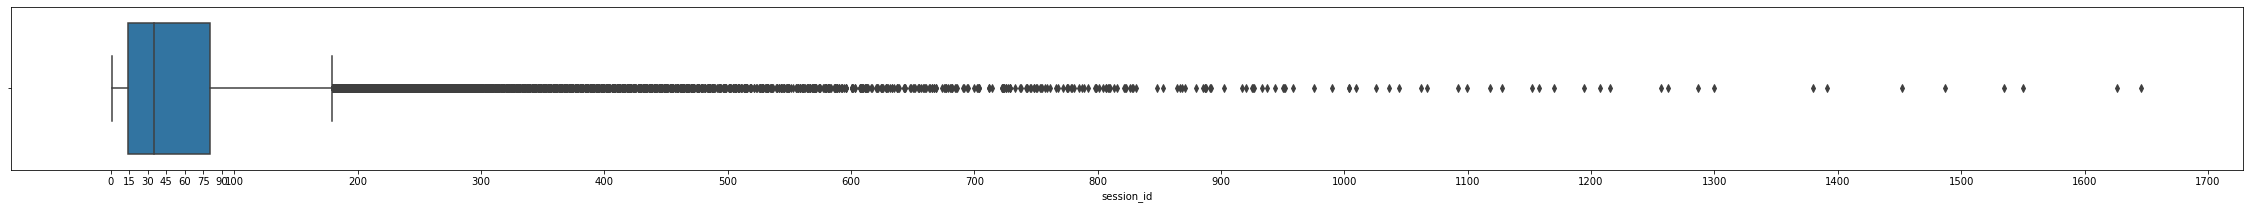

In [6]:
plt.figure(figsize=(40, 3))
plt.gca().set_xticks(list(range(0, 100, 15)) + list(range(100, 2000, 100)))
sns.boxplot(train_target.groupby("client_pin")["session_id"].count().reset_index()["session_id"])

# Data Train\Val split

In [ ]:
train_target.head()

In [21]:
class ExtractorLastNTarget():
    def __init__(self, by: str, target: str, num: int=10):
        self.num = num
        self.by = by
        self.target = target
        
    def __call__(self, X: pd.DataFrame) -> pd.DataFrame:
        """  Add last <num> <target> feature
            grouped <by> field
        """
        X_new = X.copy()
        columns = []
        for i in range(1, self.num+1):
            columns.append(f"f_last_{i}")
            X_new[f"f_last_{i}"] = X_new.groupby(self.by)[self.target].shift(i)
        X_new[columns] = X_new[columns].replace(np.NaN, "NaN") 
        return X_new   
    
    def __repr__(self):
        return f"LastNTarget {self.num}"
    
    
class ExtractorClientTargetFreq():      
    def __init__(self, column: str):
        self.column = column
        
    def __call__(self, X: pd.DataFrame) -> pd.DataFrame:
        """  Add client frequency till the moment
        """
        X_new = X.copy()
        client_freq, columns = self.prepare_user_freq_matrix(X_new)        
        X_new[columns] = client_freq[columns]  
        return X_new  
    
    def prepare_user_freq_matrix(self, X: pd.DataFrame) -> pd.DataFrame:
        X_new = X.copy()
        X_new["f_total"] = X_new.groupby("client_pin")["session_id"].cumcount()
        X_new["count_per_target"] = X_new.groupby(["client_pin", "multi_class_target"])["session_id"].cumcount()
        X_new["f_total"] = pd.to_numeric(X_new["f_total"], downcast="unsigned")
        X_new["count_per_target"] = pd.to_numeric(X_new["count_per_target"], downcast="unsigned")
        columns_names = ["f_total"]
        for t in X_new[self.column].dropna().unique():
            X_new.loc[X_new[self.column] == t, f"cum_{t}"] = X_new.loc[X_new[self.column] == t, "count_per_target"]            
            X_new[f"cum_{t}"] = X_new.groupby("client_pin")[f"cum_{t}"].fillna(method='ffill')
            X_new[f"cum_{t}"] = X_new[f"cum_{t}"].replace(np.NaN, 0)
            X_new[f"f_freq_{t}"] = X_new[f"cum_{t}"].div(X_new["f_total"])  
            X_new[f"f_freq_{t}"] = X_new[f"f_freq_{t}"].replace(np.NaN, 0)
            columns_names.append(f"f_freq_{t}")
        return X_new, columns_names
    
    def __repr__(self):
        return f"ClientTargetFreq"
    
    
class FilterMinTotal():
    """ Filter dataset by "f_total" field. 
    If <remove_index> specified  will not removed client 
    with max_f_total < <filter_min_target>
    """
    def __init__(self, index: str="client_pin", target: str="f_total", filter_min_target: int=20, remove_index: bool=False):
        self.index = index
        self.target = target
        self.filter_min_target = filter_min_target
        self.remove_index = remove_index
        
    def __call__(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()             
        X_cleared = X_copy[X_copy[self.target] >= self.filter_min_target]        
        index_array = X_copy[self.index].unique()  
        cleared_index_array = X_cleared[self.index].unique() 
        removed_index_array = np.setxor1d(index_array, cleared_index_array)
        X_filtered = X_cleared
        if len(removed_index_array) > 0:
            if self.remove_index:                 
                print(f"{self.__class__.__name__}: {len(removed_index_array)} clients were removed")
            else:
                X_copy[f"max_{self.target}"] = X_copy.groupby(self.index)[self.target].max()                 
                X_filtered = X_copy[(X_copy[self.target] >= self.filter_min_target) | (X_copy[f"max_{self.target}"] == X_copy[self.target])]  
                X_filtered = X_filtered.drop(f"max_{self.target}", axis=1)
                print(f"{self.__class__.__name__}: {len(removed_index_array)} clients were removed and merged back")
        return X_filtered
    
    def __repr__(self):
        return f"FilterMinTotal: \n {self.target} >= {self.filter_min_target} by={self.index}"
        
def create_feature(X: pd.DataFrame, feature_gen_list: list) -> pd.DataFrame:
    """ Create dataset features
    
    Attributes
    ----------
    X: pd.DataFrame
     initial feature
    y: np.ndarray
     target
    feature_config: dict
     config with feature generatation functions
    """
    X_new = X.copy()
    for fg in feature_gen_list:
        print(f"Adding feature with {fg}:-------")
        X_new = fg(X_new)
    return X_new

def filter_feature(X: pd.DataFrame, feature_filter_list: list) -> pd.DataFrame:
    X_filtered = X.copy()
    for ff in feature_filter_list:
        print(f"{ff}")
        X_filtered = ff(X_filtered)
    return X_filtered

In [24]:
feature_generator = [
    ExtractorLastNTarget(by="client_pin",
                target="multi_class_target",
                num=30),
    ExtractorClientTargetFreq(column="multi_class_target")
]

dataset_featured = create_feature(dataset, feature_generator)

Adding feature with LastNTarget 30:-------
Adding feature with ClientTargetFreq:-------


In [25]:
feature_generator_filter = [
    #FilterMinTotal(target="f_total", filter_min_target=20)
]

dataset_for_train = filter_feature(dataset_featured[~dataset_featured["test"]], feature_generator_filter)

In [26]:
dataset_featured

,client_pin,timestamp,test,session_id,multi_class_target,f_last_1,f_last_2,f_last_3,f_last_4,f_last_5,...,f_freq_statement,f_freq_mobile_recharge,f_freq_phone_money_transfer,f_freq_chat,f_freq_invest,f_freq_main_screen,f_freq_own_transfer,f_freq_card_recharge,f_freq_credit_info,f_freq_card2card_transfer
3543389,989f645a00e3e8a179036cf5fd5be29d,2020-01-01 00:00:00,False,f99d13f31091099672e51c1a02e4c567,statement,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
218041,70783113e4f4117935d9f746237fce3e,2020-01-01 00:00:00,False,da4ab6bb6795a4eb6458b88af7fb2367,mobile_recharge,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
593976,586fe605f61e81581efe72d9d3dc237d,2020-01-01 00:00:01,False,69301aa932f73dec3355b803a63c39fe,statement,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2729012,c825cc9d1dfefe1fbc0fa1ead60fe2e1,2020-01-01 00:00:23,False,c6ae8307a0214b526a0e6fca3a9b80f5,statement,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
3528582,29928aba9d9bbf5e0377ddc6ec6f5294,2020-01-01 00:00:35,False,3fd49317a617d521e0865496ec797550,mobile_recharge,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79263,4e46e206d38dcb7af41d9ced20d50ac2,2020-09-30 23:41:47,True,79263,NaN,statement,statement,statement,statement,chat,...,0.538117,0.008969,0.004484,0.156951,0.0,0.219731,0.0,0.0,0.000000,0.035874
79264,5b59bf5bd1e07775b1bc95dd7151d2cd,2020-09-30 23:43:25,True,79264,NaN,main_screen,main_screen,statement,main_screen,statement,...,0.048780,0.000000,0.000000,0.000000,0.0,0.780488,0.0,0.0,0.000000,0.048780
79265,94bcc852dd7f806f6c733056d1b0be7b,2020-09-30 23:50:37,True,79265,NaN,statement,main_screen,statement,statement,main_screen,...,0.538462,0.000000,0.000000,0.000000,0.0,0.153846,0.0,0.0,0.000000,0.000000
79266,2061f779928217eea2878fd3b605fafd,2020-09-30 23:53:03,True,79266,NaN,statement,card_recharge,credit_info,main_screen,main_screen,...,0.095238,0.000000,0.000000,0.000000,0.0,0.380952,0.0,0.0,0.238095,0.000000


In [27]:
dataset_featured.columns

Index(['client_pin', 'timestamp', 'test', 'session_id', 'multi_class_target',
       'f_last_1', 'f_last_2', 'f_last_3', 'f_last_4', 'f_last_5', 'f_last_6',
       'f_last_7', 'f_last_8', 'f_last_9', 'f_last_10', 'f_last_11',
       'f_last_12', 'f_last_13', 'f_last_14', 'f_last_15', 'f_last_16',
       'f_last_17', 'f_last_18', 'f_last_19', 'f_last_20', 'f_last_21',
       'f_last_22', 'f_last_23', 'f_last_24', 'f_last_25', 'f_last_26',
       'f_last_27', 'f_last_28', 'f_last_29', 'f_last_30', 'f_total',
       'f_freq_statement', 'f_freq_mobile_recharge',
       'f_freq_phone_money_transfer', 'f_freq_chat', 'f_freq_invest',
       'f_freq_main_screen', 'f_freq_own_transfer', 'f_freq_card_recharge',
       'f_freq_credit_info', 'f_freq_card2card_transfer'],
      dtype='object')

# Learn a model

In [28]:
features_list = [c for c in dataset_for_train.columns if c.startswith("f_")]
features_list

cat_features = [c for c in features_list if c.startswith("f_last")]
num_features = ['f_total',
 'f_freq_mobile_recharge',
 'f_freq_statement',
 'f_freq_phone_money_transfer',
 'f_freq_chat',
 'f_freq_invest',
 'f_freq_main_screen',
 'f_freq_own_transfer',
 'f_freq_card_recharge',
 'f_freq_credit_info',
 'f_freq_card2card_transfer']

In [34]:
assert dataset_for_train.timestamp.is_monotonic
X_train, X_val, y_train, y_val = train_test_split(dataset_for_train[features_list],
                                                  dataset_for_train.multi_class_target,
                                                  train_size=0.8, random_state=42, shuffle=False)
pool_train = Pool(data=X_train, label=y_train, cat_features=cat_features)
pool_val   = Pool(data=X_val, label=y_val, cat_features=cat_features)
pool_test  = Pool(data=dataset_featured.loc[dataset_featured["test"], features_list], cat_features=cat_features)

In [38]:
LOAD_MODEL = True

model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    save_snapshot=True
    # loss_function='CrossEntropy'
)

if LOAD_MODEL:
    model = CatBoostClassifier()
    model = model.load_model("model_09_01")
else:
    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        verbose=False,
        plot=True
    )
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'save_snapshot': True, 'learning_rate': 0.1, 'iterations': 200, 'loss_function': 'MultiClass', 'verbose': 0}


In [41]:
metrics = model.eval_metrics(
    data=pool_train,
    metrics=['TotalF1:average=Macro;use_weights=False'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
metrics = model.eval_metrics(
    data=pool_val,
    metrics=['TotalF1:average=Macro;use_weights=False'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [45]:
val_pred_class = model.predict(pool_val, prediction_type="Class")
val_pred_proba = model.predict_proba(pool_val)

In [93]:
map_category = np.vectorize(lambda idx: model.classes_[idx])
val_pred_max_proba = np.argmax(val_pred_proba, axis=1)
val_pred_max_proba_class = map_category(val_pred_max_proba).reshape(-1, 1)

# Model prediction_type="Class" predicts only max prob
assert np.array_equal(val_pred_class, val_pred_max_proba_class)

In [103]:
conf_mat = pd.DataFrame(confusion_matrix(pool_val.get_label(), val_pred_class), 
                        index = model.classes_,
                        columns = model.classes_)

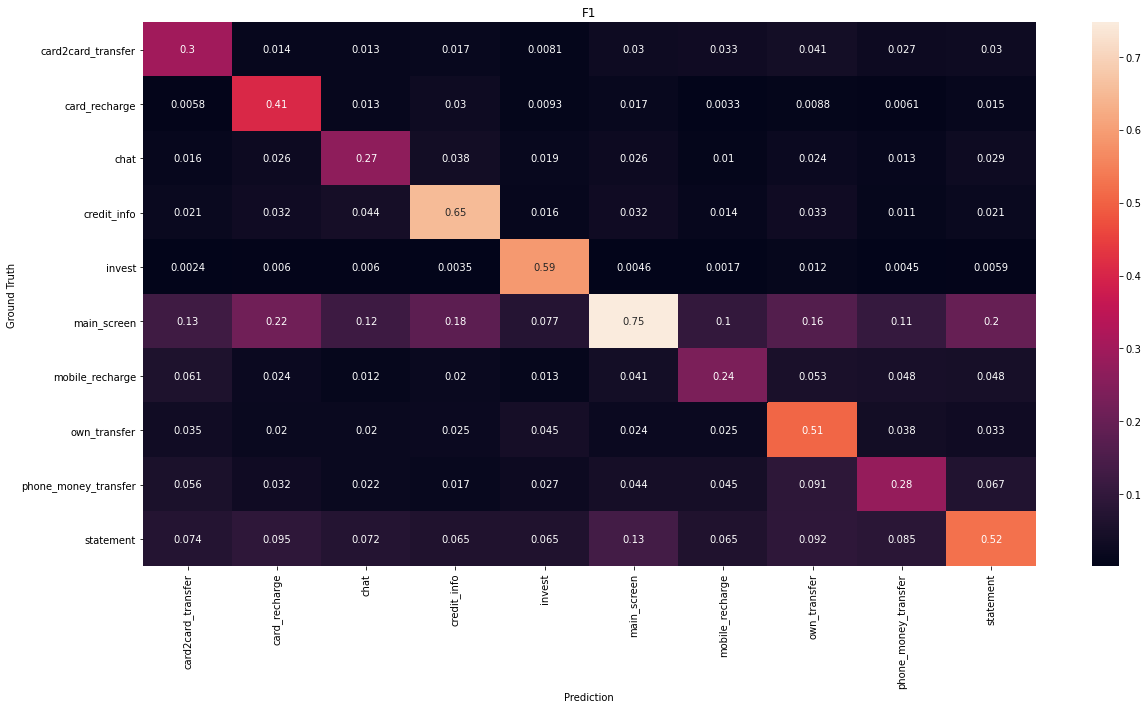

In [126]:
def f1_measure(precision, recall):
    return 2 * precision * recall / (precision + recall)

conf_mat_precision = conf_mat / conf_mat.sum(axis=0)
conf_mat_recall = conf_mat / conf_mat.sum(axis=1)
conf_mat_abs = conf_mat / conf_mat.sum()
conf_mat_f1 = f1_measure(conf_mat_precision, conf_mat_recall)

plt.figure(figsize = (20,10))
ax = sns.heatmap(conf_mat_f1, annot=True)
ax.set(xlabel='Prediction', ylabel='Ground Truth', title="F1")
plt.show()

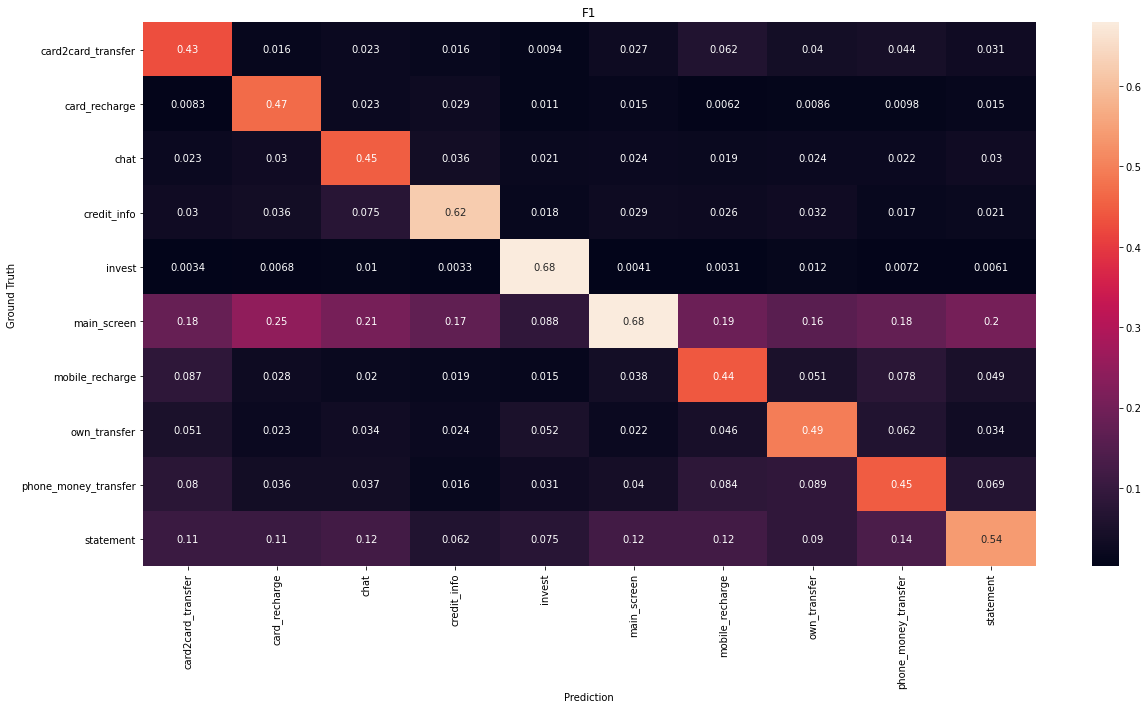

In [129]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(conf_mat_precision, annot=True)
ax.set(xlabel='Prediction', ylabel='Ground Truth', title="F1")
plt.show()

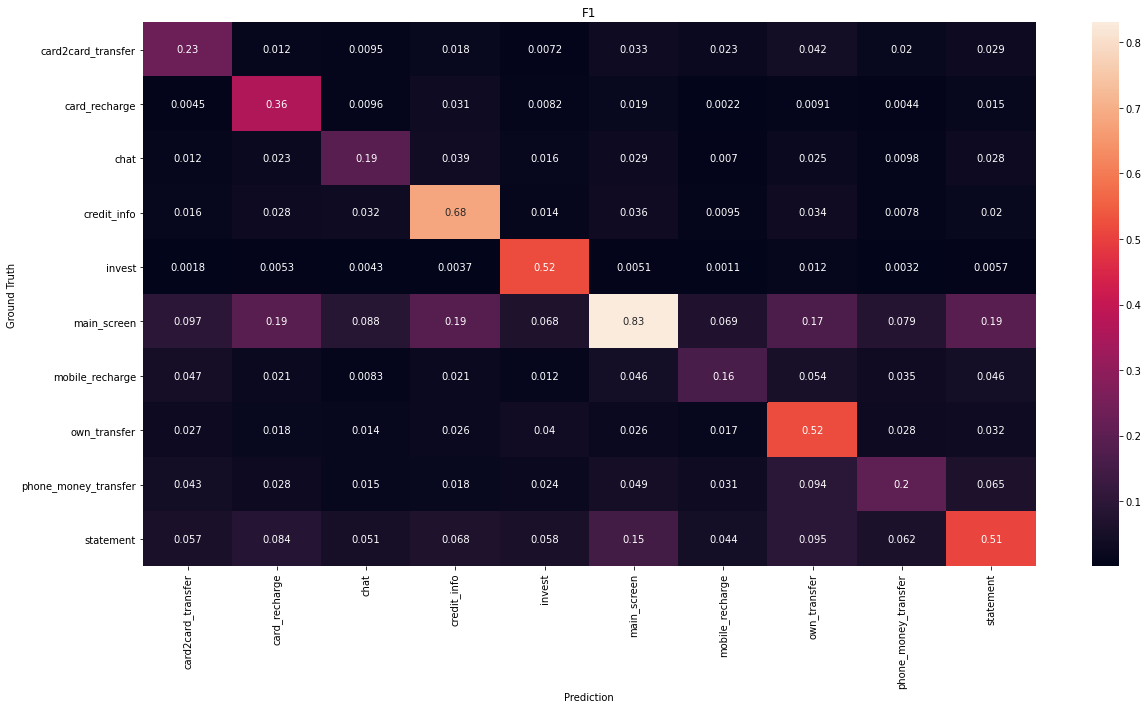

In [130]:
plt.figure(figsize = (20,10))
ax = sns.heatmap(conf_mat_recall, annot=True)
ax.set(xlabel='Prediction', ylabel='Ground Truth', title="F1")
plt.show()

In [94]:
model.feature_importances_

array(None, dtype=object)

In [68]:
# model.save_model("model_09_01", format="cbm")

# Make Prediction

In [42]:
best_model = model
prediction = pd.read_csv("alfabattle2_abattle_sample_prediction.csv")
prediction["prediction"] = pd.Series(model.predict(pool_test, prediction_type="Class").reshape(-1))
prediction.to_csv("submission.csv", index=False)
prediction

,client_pin,prediction
0,f0c674b2bb4dc64be607029271d706ec,card_recharge
1,90725b54ce77576883813d87749df6bd,main_screen
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,statement
3,831bf4c0ecccc55e536b8cfb9153d672,statement
4,3f1a5a1c492ce877af833113e59c5797,main_screen
...,...,...
79263,4e46e206d38dcb7af41d9ced20d50ac2,statement
79264,5b59bf5bd1e07775b1bc95dd7151d2cd,main_screen
79265,94bcc852dd7f806f6c733056d1b0be7b,statement
79266,2061f779928217eea2878fd3b605fafd,credit_info


# Lost in time and space

In [ ]:
    
#     def prepare_user_freq_matrix(self, X: pd.DataFrame) -> pd.DataFrame:
#         client_freq = pd.pivot_table(X, index=self.index,
#                        columns=self.column,
#                       values="session_id",
#                       aggfunc="count")
#         client_freq.replace(np.NaN, 0, inplace=True)
#         client_freq["total"] = client_freq.sum(axis=1)
#         client_freq = client_freq.div(client_freq["total"], axis=0)
#         client_freq.drop("total", axis=1, inplace=True)
#         client_freq.columns = [f"f_freq_{c}"for c in client_freq.columns]
#         client_freq.columns.name = None
#         client_freq = client_freq.reset_index()        
#         return client_freq